<a href="https://colab.research.google.com/github/cole-le/SymetraProject/blob/master/ColeLe_Symetra_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please run the codes below and upload products_to_package.csv:**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans

# Step 1: Upload and Load the Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
df = pd.read_csv(file_name)


Saving products_to_package.csv to products_to_package (1).csv


In [3]:
# Display basic info about the dataset
print("Dataset Overview:")
print(df.head())

Dataset Overview:
   set  strike   notional
0    0  1.0035  1660000.0
1    0  1.0037  3480000.0
2    0  1.0054   450000.0
3    0  1.0077   460000.0
4    0  1.0095  1470000.0


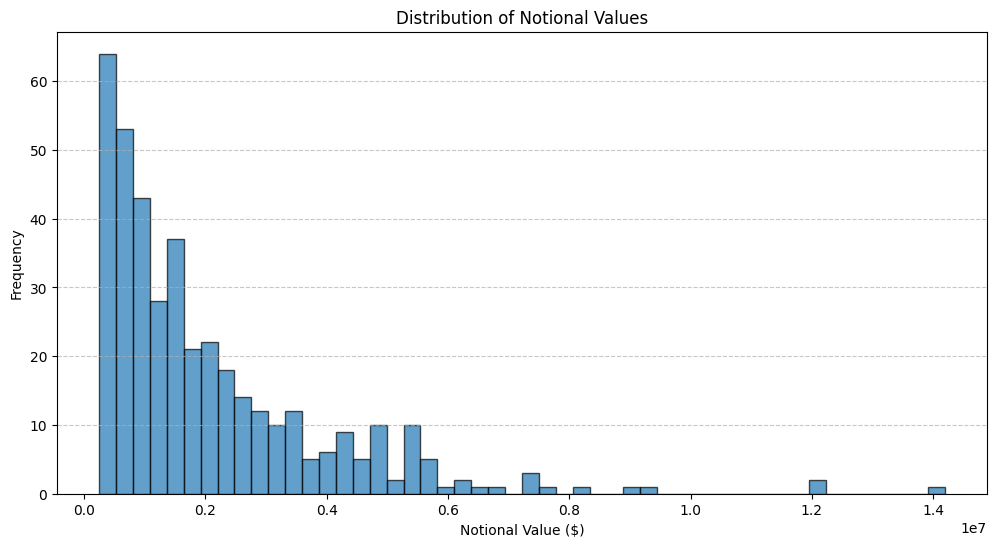

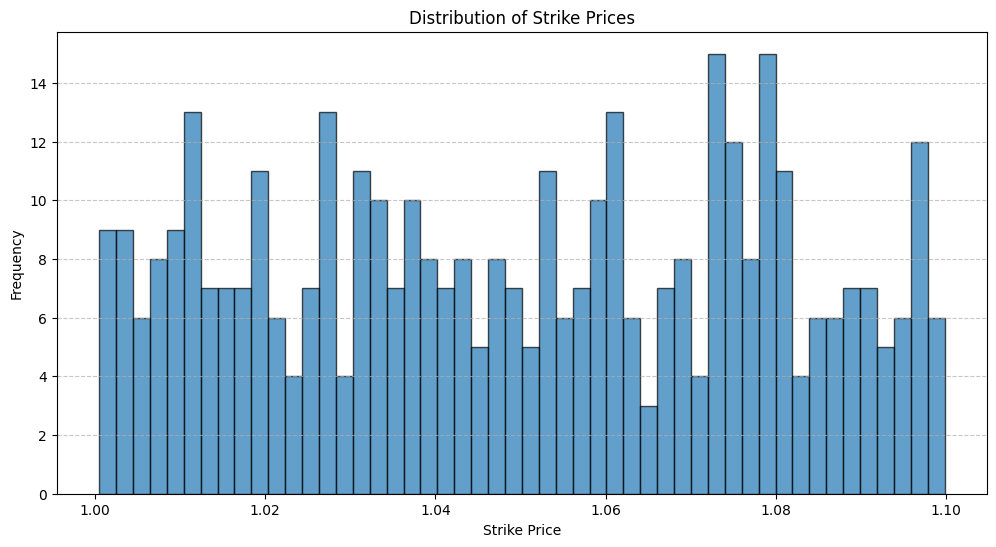

In [4]:
# Step 2: Visualize Notional and Strike Distributions
plt.figure(figsize=(12, 6))
plt.hist(df['notional'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Notional Value ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Notional Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df['strike'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Frequency')
plt.title('Distribution of Strike Prices')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

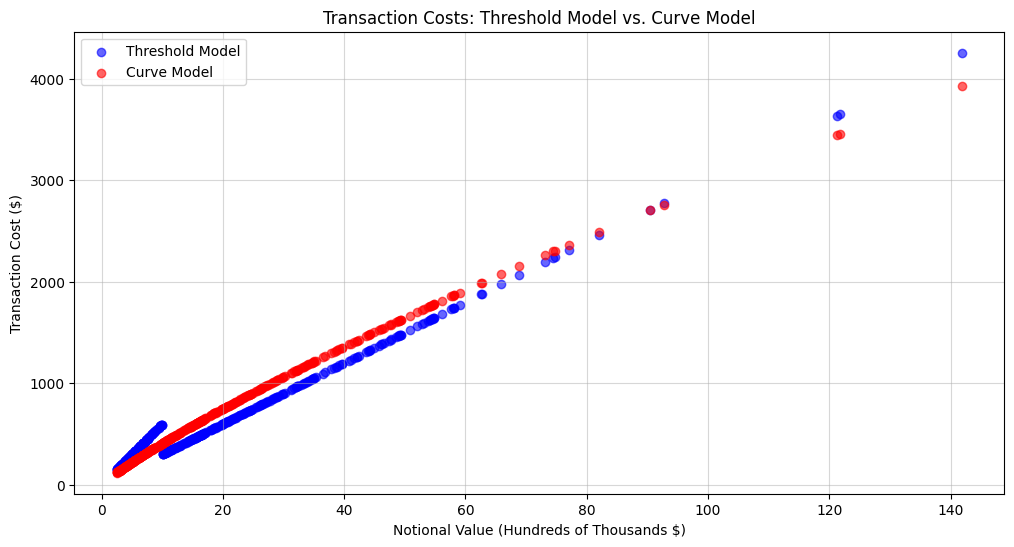

In [5]:
# Step 3: Define Transaction Cost Functions
def threshold_cost(notional):
    """Calculates transaction cost using the threshold model."""
    return 0.0006 * notional if notional <= 1_000_000 else 0.0003 * notional

def curve_cost(notional):
    """Calculates transaction cost using the curve model."""
    return (11 - (0.5 * np.log(notional))) / 10000 * notional

# Apply transaction cost models
df['threshold_cost'] = df['notional'].apply(threshold_cost)
df['curve_cost'] = df['notional'].apply(curve_cost)

# Step 4: Visualize Cost Comparisons
plt.figure(figsize=(12, 6))
plt.scatter(df['notional'] / 100000, df['threshold_cost'], color='blue', label='Threshold Model', alpha=0.6)
plt.scatter(df['notional'] / 100000, df['curve_cost'], color='red', label='Curve Model', alpha=0.6)
plt.xlabel('Notional Value (Hundreds of Thousands $)')
plt.ylabel('Transaction Cost ($)')
plt.title('Transaction Costs: Threshold Model vs. Curve Model')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


# **Results if we execute purchase at all strikes:**

In [17]:
# Step 7: Calculate Transactional Cost Without Grouping
def calculate_total_transaction_cost(data):
    """Calculates the total transaction cost if each strike is executed separately."""
    total_threshold_cost = data['notional'].apply(threshold_cost).sum()
    total_curve_cost = data['notional'].apply(curve_cost).sum()
    num_strikes = data['strike'].nunique()
    print(f"Total Transaction Cost without Grouping - Threshold Model: {total_threshold_cost}")
    print(f"Total Transaction Cost without Grouping - Curve Model: {total_curve_cost}")
    print(f"Total Number of Strikes Purchased: {num_strikes}")
    return total_threshold_cost, total_curve_cost, num_strikes

# Calculate costs without grouping
calculate_total_transaction_cost(df)

Total Transaction Cost without Grouping - Threshold Model: 275013.0
Total Transaction Cost without Grouping - Curve Model: 296068.3095506402
Total Number of Strikes Purchased: 334


(275013.0, 296068.3095506402, 334)

In [18]:
# Step 5: Implement Optimized Greedy Bin Packing Algorithm
def greedy_grouping(data, max_dist):
    """Efficiently groups strike prices based on max distance constraint and within the same set."""
    grouped_data = []
    data = data.sort_values(by=['set', 'strike']).copy()
    used = set()

    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id]
        for i, row in subset.iterrows():
            if i in used:
                continue
            base_strike = row['strike']
            group = subset[(subset['strike'] - base_strike).abs() <= max_dist]
            if not group.empty:
                grouped_data.append(group)
                used.update(group.index)
                # print(f"Group for set {set_id}: Strikes {group['strike'].tolist()}, Total Notional {group['notional'].sum()}")

    return grouped_data

# Step 6: Evaluate Different Max Distance Values
def evaluate_distances(data, distances):
    results = []
    for dist in distances:
        groups = greedy_grouping(data, dist)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in groups)
        results.append((dist, len(groups), total_cost_threshold, total_cost_curve))

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results, columns=['Max Distance', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    return results_df

# Define distance values to test
distance_values = [0.02, 0.03, 0.04, 0.08, 0.09, 0.1]
results_df = evaluate_distances(df, distance_values)



# **Results of Greedy Bin Packing Algorithm strategy:**

In [19]:
print(results_df)

   Max Distance  Num Groups  Threshold Cost     Curve Cost
0          0.02          49        419304.0  331637.211405
1          0.03          34        412716.0  302384.327902
2          0.04          30        434181.0  305610.100182
3          0.08          20        446670.0  284947.241795
4          0.09          18        422889.0  267150.630235
5          0.10          10        250194.0  155391.680485


In [28]:
# Step 7: Implement Clustering-Based Grouping Algorithm
def clustering_grouping(data, num_clusters):
    """Groups strikes using K-Means clustering algorithm."""
    clustered_data = []
    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id].copy()
        strikes = subset[['strike']].values
        if len(strikes) > num_clusters:
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(strikes)
            subset.loc[:, 'cluster'] = kmeans.labels_
            for cluster in range(num_clusters):
                group = subset[subset['cluster'] == cluster]
                clustered_data.append(group)

    return clustered_data

# Step 8: Evaluate Different Grouping Methods
def evaluate_clusters(data, cluster_values):
    results = []
    for clusters in cluster_values:
        clustered_groups = clustering_grouping(data, clusters)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in clustered_groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in clustered_groups)
        results.append((clusters, len(clustered_groups), total_cost_threshold, total_cost_curve))

    results_df = pd.DataFrame(results, columns=['Num Clusters', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    print(results_df)
    return results_df

# Define cluster values to test
cluster_values = [1,2,3, 5, 7, 10]
cluster_results_df = evaluate_clusters(df, cluster_values)


   Num Clusters  Num Groups  Threshold Cost     Curve Cost
0             1          10        250194.0  155391.680485
1             2          20        250194.0  183941.768475
2             3          30        250194.0  199734.528440
3             5          50        250194.0  219377.797793
4             7          70        250194.0  231594.933323
5            10         100        250194.0  244436.649395


## **Choosing an Optimal Grouping Distance:**
Setting max distance too low (e.g., 0.01) or choosing only one cluster (K=1) will effectively merge all strikes into a single group.
While this minimizes transaction costs, it is not realistic because execution requires spreads over multiple strikes.

Hence, the optimal solutions (Greedy Bin algorithm with max distance = 0.01 and K Cluster algorithm with K=1) which we have found so far will not be considered as optimal anymore.

In [36]:
# Step 7: Implement Cost-Optimized Dynamic Programming Grouping Algorithm
def dp_grouping(data, max_dist):
    """Groups strikes using dynamic programming to minimize transaction costs while respecting max distance constraints."""
    grouped_data = []
    data = data.sort_values(by=['set', 'strike']).copy()

    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id].copy()
        while not subset.empty:
            base_strike = subset.iloc[0]['strike']
            group = subset[(subset['strike'] - base_strike).abs() <= max_dist]

            if not group.empty:
                # Find the subset that minimizes the total transaction cost
                best_group = group.iloc[
                    np.argmin(group['notional'].apply(threshold_cost) + group['notional'].apply(curve_cost))
                ]

                # Append the best group and remove it from subset
                grouped_data.append(group)
                subset = subset.drop(group.index)

    return grouped_data

# Step 8: Evaluate DP Grouping with Different max_dist Values
def evaluate_dp_grouping(data, distances):
    results = []
    for dist in distances:
        groups = dp_grouping(data, dist)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in groups)
        results.append((dist, len(groups), total_cost_threshold, total_cost_curve))

    results_df = pd.DataFrame(results, columns=['Max Distance', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    print(results_df)
    return results_df

# Define distance values to test
distance_values = [0.02, 0.03, 0.04, 0.05, 0.07, 0.1]
evaluate_dp_grouping(df, distance_values)




   Max Distance  Num Groups  Threshold Cost     Curve Cost
0          0.02          49        250194.0  217058.644079
1          0.03          34        250194.0  203629.273977
2          0.04          30        250194.0  195204.568675
3          0.05          20        250194.0  183918.003440
4          0.07          20        250194.0  180433.615809
5          0.10          10        250194.0  155391.680485


,Max Distance,Num Groups,Threshold Cost,Curve Cost
0,0.02,49,250194.0,217058.644079
1,0.03,34,250194.0,203629.273977
2,0.04,30,250194.0,195204.568675
3,0.05,20,250194.0,183918.003440
4,0.07,20,250194.0,180433.615809
5,0.10,10,250194.0,155391.680485
